In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../7. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)

# Show the first rows
train_df.head()


,rate,rate_interpolated,log_rate,diff,Wt
date,,,,,
2015-01-06,1.1936,1.1936,0.176974,0.001509,0.001513
2015-01-07,1.1820,1.1820,0.167208,-0.009766,-0.009762
2015-01-08,1.1811,1.1811,0.166446,-0.000762,-0.000758
2015-01-09,1.1830,1.1830,0.168054,0.001607,0.001611
2015-01-12,1.1832,1.1832,0.168223,0.000169,0.000173


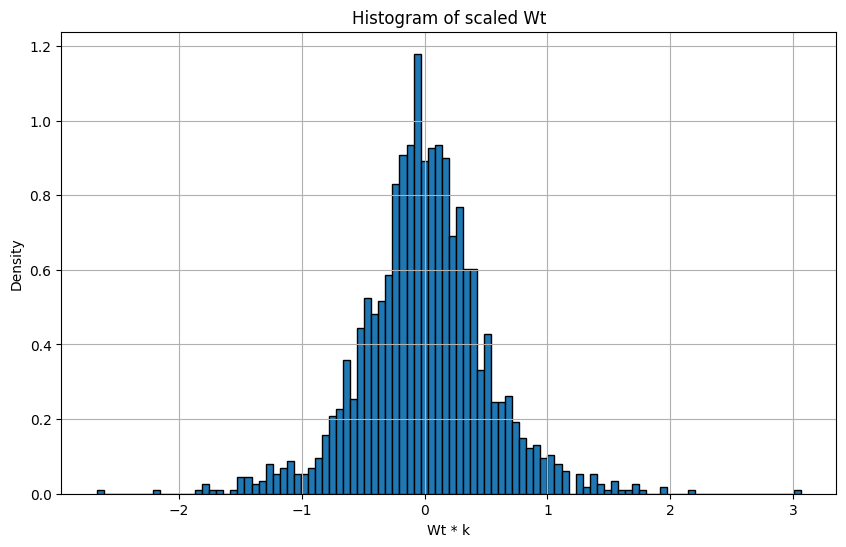

count    1996.000000
mean       -0.000050
std         0.005110
min        -0.026720
25%        -0.002754
50%        -0.000168
75%         0.002785
max         0.030646
Name: Wt, dtype: float64


In [2]:
k = 100
df= train_df.copy()
df['scaled_Wt'] = df['Wt'] * k
# basic histogram of the scaled Wt
plt.figure(figsize=(10,6))
plt.hist(df['scaled_Wt'], bins=100, edgecolor='black', density=True)
plt.title('Histogram of scaled Wt')
plt.xlabel('Wt * k')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# statistics of the original Wt
print(df['Wt'].describe())

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# ----------------------------------------
# STEP 1: Preprocessing - Discretise Wt
# ----------------------------------------
def discretise_Wt(df, k=200, bins=(-0.5, 0.5), labels=(-1, 0, 1), plot=True):
    """
    Discretise scaled Wt into categories -1, 0, +1 based on thresholds.
    Returns updated DataFrame and empirical probabilities.
    Optionally plots a histogram grouped by intervals (in %).
    """
    import matplotlib.pyplot as plt
    import numpy as np

    df = df.copy()
    df['scaled_Wt'] = df['Wt'] * k
    bin_edges = [-np.inf] + list(bins) + [np.inf]
    df['e_t'] = pd.cut(df['scaled_Wt'], bins=bin_edges, labels=labels, include_lowest=True).astype(int)

    # Generate interval labels dynamically for plotting
    plot_labels = []
    for i in range(len(bin_edges) - 1):
        left = bin_edges[i]
        right = bin_edges[i + 1]
        # Format label
        if left == -np.inf:
            label = f"(-inf, {right}]"
        elif right == np.inf:
            label = f"({left}, inf)"
        else:
            label = f"({left}, {right}]"
        plot_labels.append(label)

    # Assign intervals for plotting
    df['scaled_Wt_bin'] = pd.cut(df['scaled_Wt'], bins=bin_edges, labels=plot_labels, include_lowest=True, right=True)

    # Empirical probabilities
    prob_dist = df['e_t'].value_counts(normalize=True).sort_index()
    p = {state: prob_dist.get(state, 0) for state in labels}

    print("Empirical probabilities:")
    print(f"P(-1) = {p[-1]:.4f}, P(0) = {p[0]:.4f}, P(+1) = {p[1]:.4f}")

    if plot:
        # Count the frequency of each bin and convert to percentage
        counts = df['scaled_Wt_bin'].value_counts(sort=False)
        percentages = 100 * counts / counts.sum()

        # Plot the histogram grouped by categories
        fig, ax = plt.subplots(figsize=(8, 5))
        bars = ax.bar(plot_labels, percentages, edgecolor='black')

        # Add percentage labels on each bar, with a small offset to avoid overlap
        for bar, pct in zip(bars, percentages):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + max(percentages) * 0.03,  # 3% of max height as offset
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=11
            )

        ax.set_xlabel('Intervals of: ΔWt*k')
        ax.set_ylabel('Percentage (%)')
        ax.set_title('Histogram of scaled ΔWt (grouped by intervals)')
        ax.grid(axis='y')
        plt.xticks(rotation=45)
        plt.ylim(0, max(percentages) * 1.15)  # Add extra space on top
        plt.tight_layout()
        plt.show()

    return df, p

# ----------------------------------------
# STEP 2: Simulate discrete random walk
# ----------------------------------------

def simulate_one_discrete_path(start_value, p_dict, horizon=252, seed=42):
    """
    Simulate a single discrete random walk path (not average) using given probabilities.
    """
    if seed is not None:
        random.seed(seed)

    probs = [-1, 0, 1]
    weights = [p_dict[-1], p_dict[0], p_dict[1]]
    
    path = [start_value]
    for _ in range(horizon):
        step = random.choices(probs, weights=weights, k=1)[0]
        path.append(path[-1] + step)

    return path  # list of length (horizon + 1)

In [ ]:
def plot_and_extend_with_simulation(train_df, simulated_path, wt_col='scaled_Wt', plot_title='Simulation vs Historical'):
    """
    Combine historical data with a simulated path and plot the result.
    Assumes datetime index in train_df.
    Returns the concatenated DataFrame with all columns from train_df and simulated data.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    df = train_df.copy()
    last_date = df.index[-1]
    horizon = len(simulated_path) - 1

    # Generate future dates
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon)

    # Simulated DataFrame (only wt_col and source, but keep all columns as NaN except wt_col)
    df_sim = pd.DataFrame(index=future_dates, columns=df.columns)
    df_sim[wt_col] = simulated_path[1:]  # exclude starting value
    df_sim['source'] = 'Simulated'

    # Mark historical rows
    df['source'] = 'Historical'

    # Combine all columns from train_df and simulated data
    df_combined = pd.concat([df, df_sim])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[wt_col], label='Historical', linewidth=2)
    plt.plot(df_sim.index, df_sim[wt_col], label='Simulated', linewidth=2, linestyle='--')
    plt.axvline(x=last_date, color='gray', linestyle=':', label='Simulation start')
    plt.title(plot_title)
    plt.xlabel('Date')
    plt.ylabel('Δ ' + wt_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df_combined

Empirical probabilities:
P(-1) = 0.1363, P(0) = 0.7355, P(+1) = 0.1283


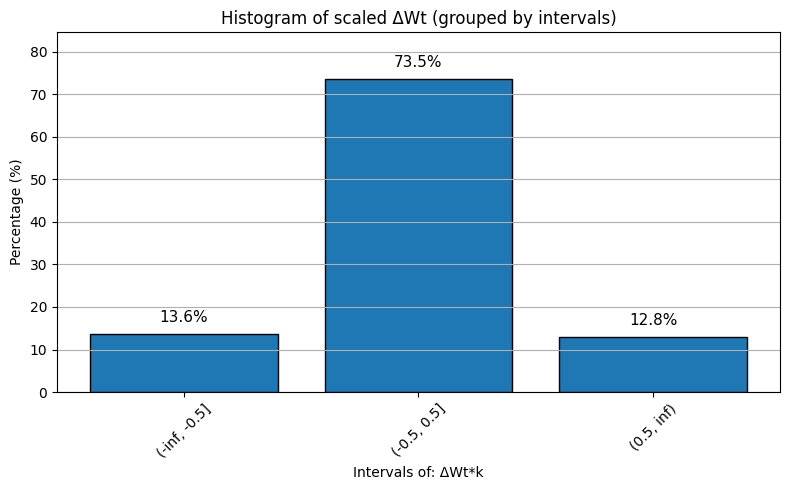

,rate,rate_interpolated,log_rate,diff,Wt,scaled_Wt,e_t,scaled_Wt_bin
date,,,,,,,,
2015-01-06,1.1936,1.1936,0.176974,0.001509,0.001513,0.151297,0,"(-0.5, 0.5]"
2015-01-07,1.1820,1.1820,0.167208,-0.009766,-0.009762,-0.976224,-1,"(-inf, -0.5]"
2015-01-08,1.1811,1.1811,0.166446,-0.000762,-0.000758,-0.075792,0,"(-0.5, 0.5]"
2015-01-09,1.1830,1.1830,0.168054,0.001607,0.001611,0.161117,0,"(-0.5, 0.5]"
2015-01-12,1.1832,1.1832,0.168223,0.000169,0.000173,0.017284,0,"(-0.5, 0.5]"


In [133]:
# ----------------------------------------
# 🧪 Example run with DEXUSEU training data
# ----------------------------------------

# Read the CSV file from the preprocessing folder
train_df = pd.read_csv('../7. preprocesing/train_df_dexuseu.csv', index_col=0, parse_dates=True)
# Step 1: Discretise Wt and get probabilities
train_df_dexuseu, p_dict = discretise_Wt(train_df, k=100)

train_df_dexuseu.head()


In [136]:
# Manual assigning of probabilities for the example
# p_dict = {-1: 0.27055, 0: 0.4589, 1: 0.27055}
p_dict = {-1: 0.13, 0: 0.74, 1: 0.13}

# Step 2: Simulate one 2-year path
path = simulate_one_discrete_path(
    start_value=train_df_dexuseu['scaled_Wt'].iloc[-1],
    p_dict=p_dict,
    horizon=365*2,  # 2 years ≈ 504 trading days
    seed=24
)

# # Step 3: Combine + plot
# df_combined = plot_and_extend_with_simulation(train_df_dexuseu, path)

In [137]:
def forecast_exchange_rate_from_simulation(train_df, simulated_path, k, mu, log_rate_col='log_rate'):
    """
    Given a simulated scaled_Wt path, reconstruct and forecast log_rates and exchange rates.
    Returns a DataFrame with forecasted log_rates and rates.
    """
    # Get last known log-rate
    X_T = train_df[log_rate_col].iloc[-1]

    # Convert simulated steps from scaled_Wt back to e_t
    steps = np.diff(simulated_path) / k  # get ΔW_t = e_t (before scaling)

    # Build W_t path: cumulative sum of e_t
    W_t_path = np.cumsum(steps)

    # Add drift: μ * t
    time_steps = np.arange(1, len(W_t_path) + 1)
    drift = mu * time_steps
    predicted_log_rates = X_T + drift + W_t_path
    predicted_rates = np.exp(predicted_log_rates)

    df_pred = pd.DataFrame({
        'log_rate_pred': predicted_log_rates,
        'rate_pred': predicted_rates
    })

    # Add dates
    last_date = train_df.index[-1]
    df_pred.index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(df_pred))

    return df_pred


In [138]:
# Assume:
# - path is your simulated scaled_Wt
# - k = 200
# - mu was estimated via linear regression on log_rate -0.000004

df_forecast = forecast_exchange_rate_from_simulation(
    train_df=train_df_dexuseu,
    simulated_path=path,
    k=100,
    mu=-0.000004 # this must be your actual drift!
)


In [139]:
df_forecast

,log_rate_pred,rate_pred
2022-12-31,0.067468,1.069796
2023-01-01,0.067464,1.069791
2023-01-02,0.067460,1.069787
2023-01-03,0.077456,1.080534
2023-01-04,0.077452,1.080530
...,...,...
2024-12-25,0.284568,1.329187
2024-12-26,0.274564,1.315956
2024-12-27,0.274560,1.315951
2024-12-28,0.264556,1.302852


In [140]:
# Export df_forecast for DEXUSEU to CSV
df_forecast.index.name = 'date'
df_forecast.to_csv('df_forecast_dexuseu.csv')

In [141]:
def plot_forecast_vs_history(train_df, df_forecast, rate_col='rate', rate_pred_col='rate_pred'):
    """
    Concatenate and plot historical rates and forecasted rates.

    Parameters:
    - train_df: DataFrame with datetime index and historical rates
    - df_forecast: DataFrame with forecasted rates (indexed by future dates)
    - rate_col: column in train_df with observed rates
    - rate_pred_col: column in df_forecast with predicted rates

    Returns:
    - combined_df: full DataFrame with both historical and forecasted data
    """
    # Historical part
    df_hist = train_df[[rate_col]].copy()
    df_hist['source'] = 'Historical'
    df_hist.rename(columns={rate_col: 'rate'}, inplace=True)

    # Forecast part
    df_fore = df_forecast[[rate_pred_col]].copy()
    df_fore.columns = ['rate']
    df_fore['source'] = 'Forecasted'

    # Concatenate
    combined_df = pd.concat([df_hist, df_fore])

    # Plot
    plt.figure(figsize=(12, 6))
    for label, group in combined_df.groupby('source'):
        plt.plot(group.index, group['rate'], label=label, linewidth=2 if label == 'Historical' else 2, linestyle='--' if label == 'Forecasted' else '-')
    
    plt.axvline(x=df_hist.index[-1], color='gray', linestyle=':', label='Forecast start')
    plt.title('Historical vs Forecasted Exchange Rate')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return combined_df


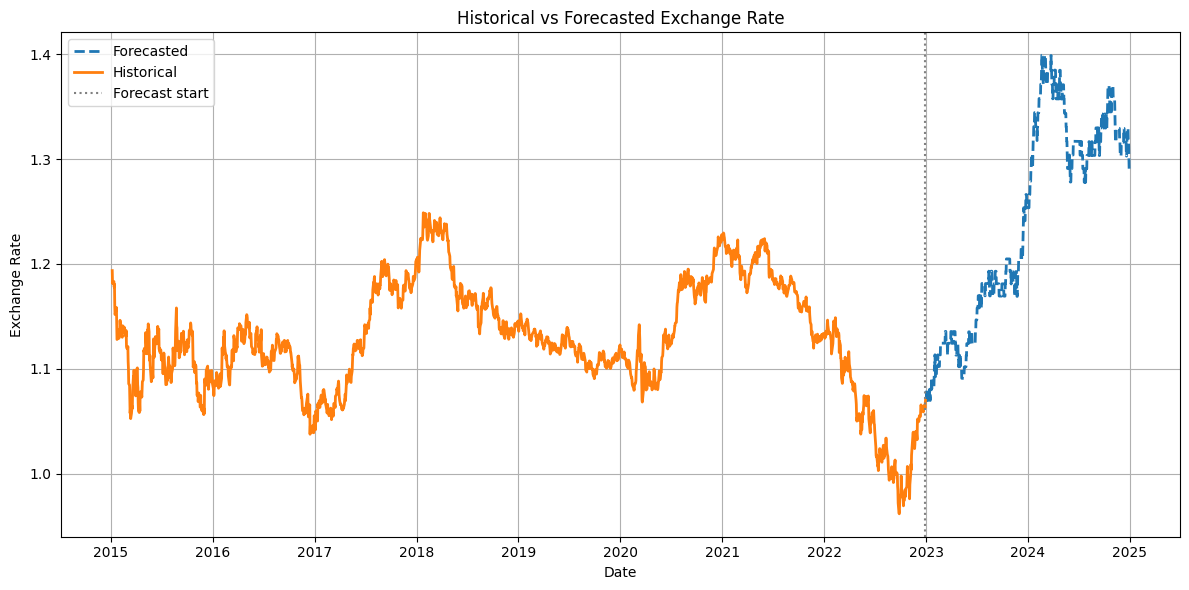

In [142]:
combined_df = plot_forecast_vs_history(train_df_dexuseu, df_forecast, rate_col='rate', rate_pred_col='rate_pred')


In [143]:
combined_df

,rate,source
date,,
2015-01-06,1.193600,Historical
2015-01-07,1.182000,Historical
2015-01-08,1.181100,Historical
2015-01-09,1.183000,Historical
2015-01-12,1.183200,Historical
...,...,...
2024-12-25,1.329187,Forecasted
2024-12-26,1.315956,Forecasted
2024-12-27,1.315951,Forecasted


In [144]:
# Export combined_df to CSV
combined_df.to_csv('forecast_df_dexuseu.csv')